In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from logger import logger
import os
%matplotlib inline
np.random.seed(0)

In [2]:
train = np.load('./data/train/train_dataset.npy')
labels = np.load('./data/train/labels.npy')

In [3]:
# Scaling data to standard mean and variance.
scaler0 = StandardScaler()
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()

train[:,:,:,0] = scaler0.fit_transform(train[:,:,:,0].reshape(-1,1)).reshape(-1,75,75)
train[:,:,:,1] = scaler1.fit_transform(train[:,:,:,1].reshape(-1,1)).reshape(-1,75,75)
train[:,:,:,2] = scaler2.fit_transform(train[:,:,:,2].reshape(-1,1)).reshape(-1,75,75)
train[:,:,:,3] = scaler3.fit_transform(train[:,:,:,3].reshape(-1,1)).reshape(-1,75,75)

print train.shape
#new_labels = np.zeros([labels.shape[0], 2])
#for i,ii in enumerate(labels):
#    if ii[0] == 0 : 
#        new_labels[i,0] = 1
#    else :
#        new_labels[i,1] = 1
#print new_labels.shape

(1604, 75, 75, 4)


In [19]:
if 1 :
    test_dataset = np.load('./data/test/test_dataset.npy')
    test_ids = np.load('./data/test/ids.npy')

    test_dataset[:,:,:,0] = scaler0.transform(test_dataset[:,:,:,0].reshape(-1,1)).reshape(-1,75,75)
    test_dataset[:,:,:,1] = scaler1.transform(test_dataset[:,:,:,1].reshape(-1,1)).reshape(-1,75,75)
    test_dataset[:,:,:,2] = scaler2.transform(test_dataset[:,:,:,2].reshape(-1,1)).reshape(-1,75,75)
    test_dataset[:,:,:,3] = scaler3.transform(test_dataset[:,:,:,3].reshape(-1,1)).reshape(-1,75,75)
    
    #test_dataset = test_dataset[:,:,:,2:4]
    print test_dataset.shape

(8424, 75, 75, 4)


In [5]:
# getting validation set
train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(train, labels, test_size=.1)


print train_dataset.shape, train_labels.shape
print valid_dataset.shape, valid_labels.shape

del train, labels

(1443, 75, 75, 4) (1443, 1)
(161, 75, 75, 4) (161, 1)


 ** A ship


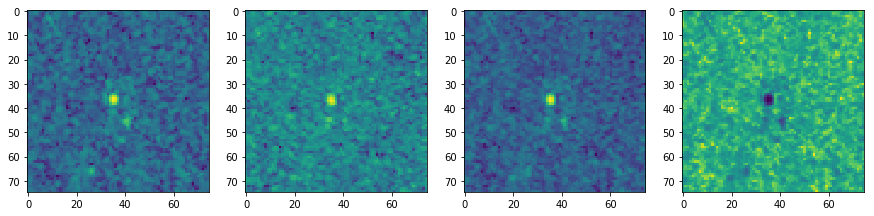

In [6]:
plt.rcParams["figure.figsize"] = [15,15]
index = np.random.randint(0, train_dataset.shape[0])
f, axarr = plt.subplots(1,4)
_ = axarr[0].imshow(train_dataset[index,:,:,0])
_ = axarr[1].imshow(train_dataset[index,:,:,1])
_ = axarr[2].imshow(train_dataset[index,:,:,2])
_ = axarr[3].imshow(train_dataset[index,:,:,3])

print " ** A ship" if train_labels[index,0] == 1 else " ** An iceberg"

In [7]:
#train_dataset = train_dataset[:,:,:,2:4]
#valid_dataset = valid_dataset[:,:,:,2:4]


In [8]:
def extract_batch(i):
    
    start_idx = (i * batch_size) % (train_dataset.shape[0] - batch_size )
    end_idx = start_idx + batch_size
    batch_data = train_dataset[ start_idx : end_idx ]
    batch_labels = train_labels[ start_idx : end_idx ]
    
    return batch_data, batch_labels.astype(np.float32)

In [9]:
def create_placeholders(n_H, n_W, n_C, n_y, name1='X', name2='Y'):
    '''
    Create X and Y placeholder, ready for each minibatch
    input : 
        n_H : height of input image
        n_W : width of input image
        n_C : number of channels per image
        n_y  : number of classes
    '''
    X = tf.placeholder(tf.float32, [None, n_H, n_W, n_C], name1)
    Y = tf.placeholder(tf.float32, [None, n_y], name2)
    
    return X,Y

In [10]:
def initialize_parameters(weight_shape, bias_shape=None):
    W = tf.get_variable("W", weight_shape, initializer=tf.contrib.layers.xavier_initializer(seed=0))
    return W, None

In [11]:
def convolution_layer(input_, training,
                      filters, kernel_size, conv_strides, 
                      pool_size, pool_strides,
                      dropout_rate) :
    
    with tf.variable_scope('conv_layer'):
                
        Z = tf.layers.conv2d(input_, filters, kernel_size, conv_strides, 'SAME', activation=tf.nn.relu)
        
        Z = tf.layers.batch_normalization(Z)
        
        Z = tf.layers.max_pooling2d(Z, pool_size, pool_strides, 'SAME')
        
        Z = tf.layers.dropout(Z, dropout_rate, training=training)
   
    return Z

In [12]:
def inference(X, training=True):
    
    with tf.variable_scope("layer_1"):
        L =  convolution_layer(X, training, filters=32, kernel_size=5, conv_strides=1,
                                pool_size=3, pool_strides=2, dropout_rate=.2)
                            
    with tf.variable_scope("layer_2"):
        L =  convolution_layer(L, training, filters=64, kernel_size=5, conv_strides=1, 
                                pool_size=3, pool_strides=2, dropout_rate=.2)
    
    with tf.variable_scope("layer_3"):
        L =  convolution_layer(L, training, filters=64, kernel_size=5, conv_strides=1, 
                                pool_size=3, pool_strides=2, dropout_rate=.2)
    
    with tf.variable_scope("layer_4"):
        L =  convolution_layer(L, training, filters=32, kernel_size=2, conv_strides=1,
                                pool_size=3, pool_strides=2, dropout_rate=.2)
    
    with tf.variable_scope("layer_5"):
        # FC layer
        L = tf.contrib.layers.flatten(L)
        L = tf.contrib.layers.fully_connected(L,1024, activation_fn=tf.nn.relu)
        L = tf.layers.batch_normalization(L)
        # dropout layer
        L = tf.layers.dropout(L, rate=.2, training=training)
        
    with tf.variable_scope("layer_6"):
        # FC layer
        L = tf.contrib.layers.fully_connected(L, 512, activation_fn=tf.nn.relu)
        L = tf.layers.batch_normalization(L)
        # dropout layer
        L = tf.layers.dropout(L, rate=.2, training=training)
    
    with tf.variable_scope("layer_7"):
        # FC layer
        L = tf.contrib.layers.fully_connected(L, 64, activation_fn=tf.nn.relu)
        L = tf.layers.batch_normalization(L)
        # dropout layer
        L = tf.layers.dropout(L, rate=.2, training=training)
    
    with tf.variable_scope("layer_8"):
        # FC layer
        L = tf.contrib.layers.fully_connected(L, 32, activation_fn=tf.nn.relu)
        L = tf.layers.batch_normalization(L)
        # dropout layer
        L = tf.layers.dropout(L, rate=.2, training=training)
        
    with tf.variable_scope("layer_9"):
        # FC layer
        L = tf.contrib.layers.fully_connected(L, 1, activation_fn=None)
        print L
    return L

In [13]:
def compute_loss(Z, Y):
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z, labels=Y))
    return loss

In [14]:
def optimize(loss, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(loss, global_step=global_step) 
    return optimizer

In [15]:
def get_summary(loss, tf_valid_loss):
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('valid_loss', tf_valid_loss)
    return tf.summary.merge_all()

In [16]:
def predict_test():
    f = open('./data/submission.csv', 'wb')
    f.write('id,is_iceberg\n')
    print "\npredicting test dataset"
    step = 200
    n_steps = test_dataset.shape[0] / step
    for sind in range(0,test_dataset.shape[0], step) :
        print "step", sind/step, 'of', n_steps, '....'
        #-----------------------------------
        eind = sind + step
        if eind > test_dataset.shape[0] :
            eind = test_dataset.shape[0]
         #--------------------------------------
        test_pred = sess.run(tf_test_pred, feed_dict={X_test : test_dataset[sind:eind]})
        for e1, e2 in zip(test_ids[sind:eind], test_pred):
            f.write('{},{}\n'.format(e1,e2[0]))
    f.close()
    print "finished predicting\n"
    return

In [17]:
# Defining Model graph :
learning_rate = 0.001
n_H, n_W, n_C = train_dataset.shape[1:]
n_y = train_labels.shape[1]

graph = tf.Graph()
with graph.as_default():
    
    with tf.variable_scope('input_data'):
        X, Y = create_placeholders(n_H, n_W, n_C, n_y)
        X_valid, Y_valid = create_placeholders(n_H, n_W, n_C, n_y, 'X_valid', 'Y_valid')
        X_test = tf.placeholder(tf.float32, [None, n_H, n_W, n_C], name='X_test')
        
    with tf.variable_scope('forward_propogation', reuse=tf.AUTO_REUSE):
        Z = inference(X)
        Z_valid = inference(X_valid, training=False)
        Z_test = inference(X_test, training=False)
    
    with tf.variable_scope('loss'):
        tf_loss = compute_loss(Z, Y)
        tf_loss_valid = compute_loss(Z_valid, Y_valid)
    
    with tf.variable_scope('training'):
        global_step = tf.Variable(0, name='global_step',trainable=False)
        optimizer = optimize(tf_loss, global_step)
    
    with tf.variable_scope('summary'):
        summary_writer = tf.summary.FileWriter('./tmp/logs/', graph)
        summary = get_summary(tf_loss, tf_loss_valid)
    
    with tf.variable_scope('model_saver'):
        saver = tf.train.Saver()
    
    with tf.variable_scope('test_predictions'):
        tf_test_pred = tf.sigmoid(Z_test)
    

Tensor("forward_propogation/layer_9/fully_connected/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("forward_propogation/layer_9_1/fully_connected/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("forward_propogation/layer_9_2/fully_connected/BiasAdd:0", shape=(?, 1), dtype=float32)


In [18]:
# defining Session to run all the above.
# displaying paramters
avg_loss = 0
avg_valid_loss = 0
display_step = 20
#----------------------------
saving_step = 50
batch_size = 24
epoches = 2000
# early stopping parameters
best_loss = 999
ESRounds = 200
rounds = 0
#----------------------------
# intialize logfile
logging = True
if logging : 
    files = os.listdir('./tmp/onrun-log/')
    files.sort()
    log = logger('{}.log'.format(int(files[-1].split('.')[0])+1), log_dir='./tmp/onrun-log/')
    log.add("epoches = {}, batch_size = {}, ESRounds = {}, training shape = {}, validation shape = {},"
            " Run on {}\n------"\
            .format(epoches,batch_size,ESRounds,train_dataset.shape,valid_dataset.shape,np.datetime64('now')))
    print "Log file is ready."
#------------------------------
with tf.Session(graph=graph) as sess:
    
    tf.global_variables_initializer().run()

    #summary_writer = tf.summary.FileWriter('./tmp/logs/', sess.graph)
    
    for i in range(epoches):
        
        batch_data, batch_labels = extract_batch(i)
        feed_dict = { X : batch_data, Y : batch_labels, X_valid : valid_dataset, Y_valid : valid_labels }
        _, l, valid_loss = sess.run([optimizer, tf_loss, tf_loss_valid], feed_dict=feed_dict)
        avg_loss += l
        avg_valid_loss += valid_loss
        
        # Print loss after each N display steps, also add summary to file.
        if i % display_step == 0 :
            avg_loss /= display_step
            avg_valid_loss /= display_step
            #feed_dict[X_valid] = valid_dataset
            #feed_dict[Y_valid] = valid_labels
            summary_str = sess.run(summary, feed_dict=feed_dict)
            _ = summary_writer.add_summary(summary_str, sess.run(global_step))
           
            print "Finished ", i, " steps,\t loss : ", avg_loss, ",\t valid loss : ", avg_valid_loss
            if logging : log.add("Finished {} steps,\t loss : {},\t valid loss : {} "\
                               .format(i,avg_loss,avg_valid_loss))
            avg_loss = 0
            avg_valid_loss = 0
            
        # ADD early stopping Step.
        if valid_loss < best_loss and i > 0 :
            print "New best loss : {}, on round : {} and step : {}".format(valid_loss,rounds,i)
            log.add("New best loss : {}, on round : {} and step : {}".format(valid_loss,rounds,i))
            best_loss = valid_loss
            rounds = 0
            _ = saver.save(sess, './tmp/model_checkpoints/model-ckpt-best')
        else :
            if rounds == ESRounds :
                print "reached the specified early stopping rounds [{}]\n.Stopping Model.".format(ESRounds)
                if logging : log.add("reached the specified early stopping rounds [{}]\n.Stopping Model."\
                                     .format(ESRounds))
                summary_writer.close()
                break
            rounds += 1
        
        #if i % saving_step == 0 and i > 0:
        #    print "Saving model"
        #    _ = saver.save(sess, './tmp/model_checkpoints/model-checkpoint', global_step=global_step)
    # predict test_data
    #predict_test()
    summary_writer.close()

    

Log file is ready.
Finished  0  steps,	 loss :  0.0575020849705 ,	 valid loss :  0.0337427467108
New best loss : 0.678053975105, on round : 1 and step : 1
New best loss : 0.672411739826, on round : 2 and step : 4
New best loss : 0.671744287014, on round : 8 and step : 13
New best loss : 0.670678913593, on round : 0 and step : 14
New best loss : 0.667205691338, on round : 0 and step : 15
New best loss : 0.661731660366, on round : 0 and step : 16
New best loss : 0.657705724239, on round : 0 and step : 17
Finished  20  steps,	 loss :  0.704537186027 ,	 valid loss :  0.674693349004
New best loss : 0.652174472809, on round : 10 and step : 28
New best loss : 0.636645793915, on round : 0 and step : 29
New best loss : 0.627358734608, on round : 0 and step : 30
New best loss : 0.622667372227, on round : 0 and step : 31
Finished  40  steps,	 loss :  0.664475342631 ,	 valid loss :  0.656973484159
New best loss : 0.613405406475, on round : 8 and step : 40
New best loss : 0.599499166012, on round :

In [ ]:
train_dataset = train_dataset[:,:,:,2:4].reshape(-1,75,75,2)
valid_dataset = valid_dataset[:,:,:,2:4].reshape(-1,75,75,2)

In [20]:
with tf.Session(graph=graph) as sess :
    _ = saver.restore(sess, './tmp/model_checkpoints/model-ckpt-best')
    valid_loss = sess.run(tf_loss_valid, {X_valid:valid_dataset, Y_valid:valid_labels})
    print valid_loss
    predict_test()

INFO:tensorflow:Restoring parameters from ./tmp/model_checkpoints/model-ckpt-best
0.278384

predicting test dataset
step 0 of 42 ....
step 1 of 42 ....
step 2 of 42 ....
step 3 of 42 ....
step 4 of 42 ....
step 5 of 42 ....
step 6 of 42 ....
step 7 of 42 ....
step 8 of 42 ....
step 9 of 42 ....
step 10 of 42 ....
step 11 of 42 ....
step 12 of 42 ....
step 13 of 42 ....
step 14 of 42 ....
step 15 of 42 ....
step 16 of 42 ....
step 17 of 42 ....
step 18 of 42 ....
step 19 of 42 ....
step 20 of 42 ....
step 21 of 42 ....
step 22 of 42 ....
step 23 of 42 ....
step 24 of 42 ....
step 25 of 42 ....
step 26 of 42 ....
step 27 of 42 ....
step 28 of 42 ....
step 29 of 42 ....
step 30 of 42 ....
step 31 of 42 ....
step 32 of 42 ....
step 33 of 42 ....
step 34 of 42 ....
step 35 of 42 ....
step 36 of 42 ....
step 37 of 42 ....
step 38 of 42 ....
step 39 of 42 ....
step 40 of 42 ....
step 41 of 42 ....
step 42 of 42 ....
finished predicting



In [ ]:
summary_writer.add_summary(summary_str)

In [ ]:
test_dataset.shape